# Exploring Neural Networks - MNIST

### MNIST Digit Prediction


In [2]:
# Import necessary libraries
# For data handling, visualization, and modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

- Normalization helps since the model converges faster and it prevents extreme values from dominating influence towards final output. 

- ToTensor() normalizes the input array to value between 0 to 1 hence no further normalization seems necessary

In [4]:
# loading the data with preprocessing in-built
transform_mnist = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

In [5]:
# Load the dataset from torchvision.datasets
trainval_dataset = datasets.MNIST(root="./mnist_data", train=True, download=True, transform=transform_mnist)
test_dataset = datasets.MNIST(root="./mnist_data", train=False, download=True, transform=transform_mnist)

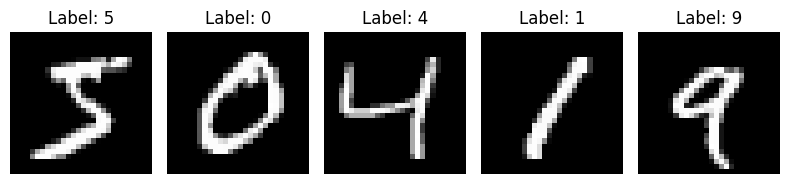

In [6]:
# Display a sample of the dataset images and their transformed values
plt.figure(figsize=(8, 2))
for i in range(5):
    image, label = trainval_dataset[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Show transformed values for one image
print("Transformed image values:")
print(trainval_dataset[0][0].squeeze().numpy())

Transformed image values:
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.

### Baseline Model - Random Forest

In [17]:
# Flatten and normalize input
X_train = trainval_dataset.data.numpy().reshape(len(trainval_dataset), -1) / 255.0  
Y_train = trainval_dataset.targets.numpy()

X_test = test_dataset.data.numpy().reshape(len(test_dataset), -1) / 255.0
Y_test = test_dataset.targets.numpy()

In [18]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=seed)

# Train Random Forest on flattened training data
rf.fit(X_train, Y_train)

# Predict and evaluate
rf_predictions = rf.predict(X_test)
rf_accuracy = accuracy_score(Y_test, rf_predictions)
print(f"Random Forest Test Accuracy: {rf_accuracy * 100:.2f}%")

print("\nClassification Report for Random Forest:")
print(classification_report(Y_test, rf_predictions))

Random Forest Test Accuracy: 97.04%

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Neural Networks - MLP Model

In [8]:
# Split the trainval_dataset
train_data, val_data = torch.utils.data.random_split(trainval_dataset, [50000, 10000])

In [9]:
# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# Define a simple Neural Network
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        # Choosing 2 hidden layers with 128 and 64 units respectively as a balance between simplicity and expressiveness
        self.fc1 = nn.Linear(28 * 28, 128)  # First layer
        self.fc2 = nn.Linear(128, 64)       # Second layer
        self.fc3 = nn.Linear(64, 10)        # Output layer for 10 classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation chosen for non-linearity and efficiency
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for Output since Loss function nn.CrossEntropyLoss applies it
        return x

Why no softmax in the output layer?
- For multi-class classification, softmax is implicitly applied by nn.CrossEntropyLoss, which combines 
- log-softmax and negative log-likelihood. This ensures numerical stability and avoids redundancy.

In [11]:
# Train the Neural Network
# Initialize model, loss function, and optimizer
mnist_nn_model = SimpleNeuralNet()
# CrossEntropyLoss is appropriate for multi-class classification tasks
criterion = nn.CrossEntropyLoss()
# Adam optimizer is chosen for its adaptive learning rates and fast convergence
optimizer = optim.Adam(mnist_nn_model.parameters(), lr=0.001)


In [12]:
# Training loop with validation tracking
train_losses, val_losses = [], []

def train_nn(model, train_loader, val_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            # gradients are zeroed
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss (applies log-softmax internally via nn.CrossEntropyLoss)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loss
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")


In [15]:
# To evaluate the model on the test set
def evaluate_nn(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Argmax to get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Neural Network Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy


In [13]:
train_nn(mnist_nn_model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch 1, Training Loss: 0.4216, Validation Loss: 0.2746
Epoch 2, Training Loss: 0.2111, Validation Loss: 0.2168
Epoch 3, Training Loss: 0.1571, Validation Loss: 0.1729
Epoch 4, Training Loss: 0.1290, Validation Loss: 0.1492
Epoch 5, Training Loss: 0.1059, Validation Loss: 0.1581


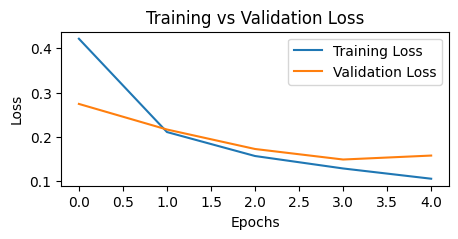

Neural Network Test Accuracy: 95.89%


0.9589

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(5, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

nn_accuracy = evaluate_nn(mnist_nn_model, test_loader)

In [21]:
# Comparison of NN and Baseline RF
print("\nModel Comparison:")
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(f"Neural Network Accuracy: {nn_accuracy * 100:.2f}%")



Model Comparison:
Random Forest Accuracy: 97.04%
Neural Network Accuracy: 95.89%


In [20]:
import pandas as pd
accuracy_df = pd.DataFrame({"Baseline RandomForest":[rf_accuracy], "Simple NN":[nn_accuracy]})
accuracy_df

,Baseline RandomForest,Simple NN
0,0.9704,0.9589


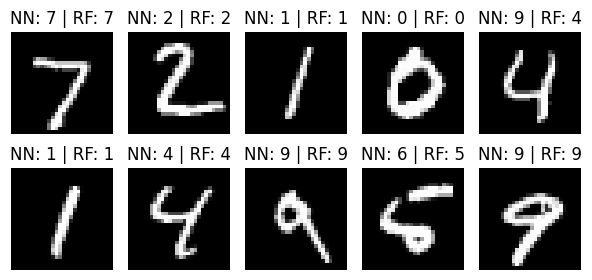

In [23]:
# Visualize predictions from both models
samples = X_test[:10].reshape(-1, 28, 28)  # First 10 samples
nn_preds = []
mnist_nn_model.eval()
with torch.no_grad():
    for sample in X_test[:10]:
        sample_tensor = torch.tensor(sample, dtype=torch.float32).view(1, 1, 28, 28)
        nn_output = mnist_nn_model(sample_tensor)
        _, nn_pred = torch.max(nn_output, 1)
        nn_preds.append(nn_pred.item())

plt.figure(figsize=(6, 3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples[i], cmap="gray")
    plt.title(f"NN: {nn_preds[i]} | RF: {rf_predictions[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Improve the Neural Net

### Strategy 1: Architecture Optimizations
 ##### Increase layer counts, neuron count and add/drop dropout regularization
 - First, Add layer and neurons
 - Second, add Dropout regularization 
 - Increase Neurons further

 ( RE-USING THE SAME CODE BELOW BUT TRAINING/TESTING SEPARATELY AS BELOW)

In [34]:
# Below code is resused for the runs/results below with modification so the final saved code will match only one config for below results
# Redefine the Neural Network with Optimized Architecture and Regularization
class SimpleNeuralNetV2(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetV2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)  # Increased neurons in the first layer
        self.fc2 = nn.Linear(256, 128)      # Increased neurons in the second layer
        self.fc3 = nn.Linear(128, 10)       # Output layer
        self.dropout = nn.Dropout(0.2)     # Commented out for Arch1 run below

    def forward(self, x):
        x = x.view(-1, 28 * 28)            # Flatten the image
        x = torch.relu(self.fc1(x))        # ReLU activation
        x = self.dropout(x)                # Apply dropout
        x = torch.relu(self.fc2(x))        # ReLU activation
        x = self.dropout(x)                # Apply dropout
        x = self.fc3(x)                    # Output layer
        return x

Epoch 1, Training Loss: 0.3743, Validation Loss: 0.2267
Epoch 2, Training Loss: 0.1703, Validation Loss: 0.1427
Epoch 3, Training Loss: 0.1252, Validation Loss: 0.1444
Epoch 4, Training Loss: 0.0998, Validation Loss: 0.1100
Epoch 5, Training Loss: 0.0831, Validation Loss: 0.1223


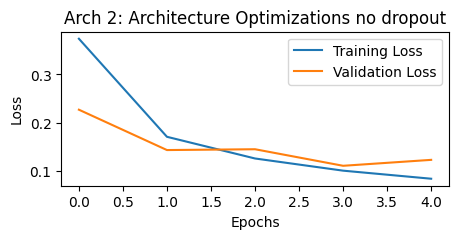

Neural Network Test Accuracy: 96.52%


In [31]:
### Arch 2: Architecture Optimizations no dropout
train_losses, val_losses = [], []
criterion = nn.CrossEntropyLoss() #same as first run

mnist_nn_model_v2_a2 = SimpleNeuralNetV2()
optimizer = optim.Adam(mnist_nn_model_v2_a2.parameters(), lr=0.001) #same optimizer and LR as first run

train_nn(mnist_nn_model_v2_a2, train_loader, val_loader, criterion, optimizer, epochs=5)
# Plot training and validation loss
plt.figure(figsize=(5, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Arch 2: Architecture Optimizations no dropout')
plt.legend()
plt.show()

nn_accuracy_v2_a2 = evaluate_nn(mnist_nn_model_v2_a2, test_loader)

In [33]:
accuracy_df["Arch2 = Simple NN+layer+neurons"] = nn_accuracy_v2_a2
accuracy_df

,Baseline RandomForest,Simple NN,Arch2 = Simple NN+layer+neurons
0,0.9704,0.9589,0.9652


- Addition of layers and neurons has increased the accuracy so lets keep the modification

Epoch 1, Training Loss: 0.4275, Validation Loss: 0.2085
Epoch 2, Training Loss: 0.1605, Validation Loss: 0.1645
Epoch 3, Training Loss: 0.1218, Validation Loss: 0.1517
Epoch 4, Training Loss: 0.0932, Validation Loss: 0.1341
Epoch 5, Training Loss: 0.0757, Validation Loss: 0.1101


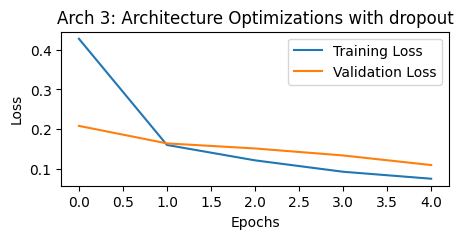

Neural Network Test Accuracy: 97.11%


In [35]:
### Arch 3: Architecture Optimizations with Dropout(0.2)
train_losses, val_losses = [], []
criterion = nn.CrossEntropyLoss() #same as first run

mnist_nn_model_v2_a3 = SimpleNeuralNetV2()
optimizer = optim.Adam(mnist_nn_model_v2_a3.parameters(), lr=0.001) #same optimizer and LR as first run

train_nn(mnist_nn_model_v2_a3, train_loader, val_loader, criterion, optimizer, epochs=5)

# Plot training and validation loss
plt.figure(figsize=(5, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Arch 3: Architecture Optimizations with dropout')
plt.legend()
plt.show()

nn_accuracy_v2_a3 = evaluate_nn(mnist_nn_model_v2_a3, test_loader)

In [36]:
accuracy_df["Arch3 = Arch2 + Dropout"] = nn_accuracy_v2_a3
accuracy_df

,Baseline RandomForest,Simple NN,Arch2 = Simple NN+layer+neurons,Arch3 = Arch2 + Dropout
0,0.9704,0.9589,0.9652,0.9711


- Addition of Dropout has increased the Accuracy by very small percentage. This is not expected since Dropout intentionally introduces noise and preventing overfitting but it is so small we will neglect the increase. Regardless, we expect the net to generalize better so we are keeping the dropout

##### Arch 4: Add Third Hidden Layer and add more neurons

In [37]:
# Define a new architecture without dropout
class SimpleNeuralNetV3(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetV3, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # Increased neurons in the first layer
        self.fc2 = nn.Linear(512, 256)      # Second layer with fewer neurons
        self.fc3 = nn.Linear(256, 128)      # Third layer with fewer neurons
        self.fc4 = nn.Linear(128, 10)       # Output layer with 10 classes
        self.dropout = nn.Dropout(0.3)     # Commented out for Arch1 run below

    def forward(self, x):
        x = x.view(-1, 28 * 28)            # Flatten the image
        x = torch.relu(self.fc1(x))        # ReLU activation
        x = self.dropout(x)                # Apply dropout
        x = torch.relu(self.fc2(x))        # ReLU activation
        x = self.dropout(x)                # Apply dropout
        x = torch.relu(self.fc3(x))        # ReLU activation
        x = self.dropout(x)                # Apply dropout
        x = self.fc4(x)                    # Output layer
        return x

Epoch 1, Training Loss: 0.4820, Validation Loss: 0.2264
Epoch 2, Training Loss: 0.1591, Validation Loss: 0.1528
Epoch 3, Training Loss: 0.1131, Validation Loss: 0.1449
Epoch 4, Training Loss: 0.0932, Validation Loss: 0.1236
Epoch 5, Training Loss: 0.0837, Validation Loss: 0.1190


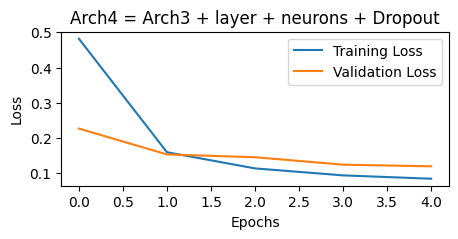

Neural Network Test Accuracy: 96.76%


In [38]:
train_losses, val_losses = [], []
criterion = nn.CrossEntropyLoss() #same as first run

mnist_nn_model_v3 = SimpleNeuralNetV3()
optimizer = optim.Adam(mnist_nn_model_v3.parameters(), lr=0.001) #same optimizer and LR as first run

train_nn(mnist_nn_model_v3, train_loader, val_loader, criterion, optimizer, epochs=5)
# Plot training and validation loss
plt.figure(figsize=(5, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Arch4 = Arch3 + layer + neurons + Dropout")
plt.legend()
plt.show()

nn_accuracy_v3 = evaluate_nn(mnist_nn_model_v3, test_loader)

- Can we keep on increasing the layers, neurons, with more regularization? But sometimes, it does not help as seen above - Drop in accuracy. Increase in hidden layers, neurons while with higher dropout (0.3) leds to lower accuracy than a more simpler architecture we have used above. We'll stick to the simpler architecutre. 

## Epoch
 - Lets increase the epoch with the original attempt and see how it affects the results

Epoch 1, Training Loss: 0.4316, Validation Loss: 0.2998
Epoch 2, Training Loss: 0.2074, Validation Loss: 0.1814
Epoch 3, Training Loss: 0.1469, Validation Loss: 0.1961
Epoch 4, Training Loss: 0.1183, Validation Loss: 0.1351
Epoch 5, Training Loss: 0.1003, Validation Loss: 0.1257
Epoch 6, Training Loss: 0.0887, Validation Loss: 0.1121
Epoch 7, Training Loss: 0.0754, Validation Loss: 0.1235
Epoch 8, Training Loss: 0.0703, Validation Loss: 0.1106
Epoch 9, Training Loss: 0.0623, Validation Loss: 0.1236
Epoch 10, Training Loss: 0.0606, Validation Loss: 0.1120


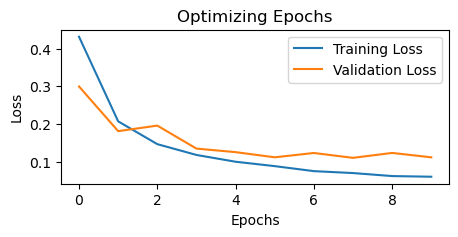

Neural Network Test Accuracy: 97.14%


In [90]:
### Attempt 4: Increase Epochs
train_losses, val_losses = [], []
criterion = nn.CrossEntropyLoss() #same as first run

mnist_nn_model_optiepoch = SimpleNeuralNet()
optimizer = optim.Adam(mnist_nn_model_optiepoch.parameters(), lr=0.001) #same optimizer and LR as first run

train_nn(mnist_nn_model_optiepoch, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot training and validation loss
plt.figure(figsize=(5, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Optimizing Epochs')
plt.legend()
plt.show()

nn_accuracy_optiepoch = evaluate_nn(mnist_nn_model_optiepoch, test_loader)

 - Accuracy has certainly peaked while time also doubled but look at the drop in training loss and increasing validation, which indicate overfitting. We might need to include Early Stopping which prevents the NN to overfit by stopping the training when it sees the Validation loss increasing
 - Early Stopping with Patience is an approach where you run few more runs to give the increasing validation loss some grace. Implemented below

In [91]:
import numpy as np

def train_earlystop_patience(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=2):
    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Print losses for this epoch
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break


Epoch 1, Training Loss: 0.4246, Validation Loss: 0.2566
Epoch 2, Training Loss: 0.1992, Validation Loss: 0.1819
Epoch 3, Training Loss: 0.1470, Validation Loss: 0.1624
Epoch 4, Training Loss: 0.1177, Validation Loss: 0.1307
Epoch 5, Training Loss: 0.0992, Validation Loss: 0.1195
Epoch 6, Training Loss: 0.0894, Validation Loss: 0.1526
Epoch 7, Training Loss: 0.0775, Validation Loss: 0.1283
Early stopping triggered at epoch 7


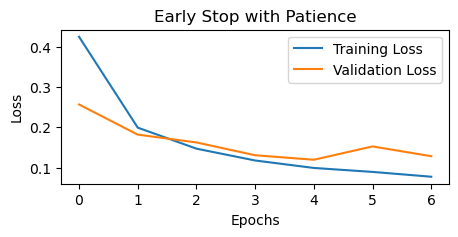

Neural Network Test Accuracy: 96.68%


In [92]:
### Attempt 5: First Architecture and Early Stop with Patience
train_losses, val_losses = [], []
criterion = nn.CrossEntropyLoss() #same as first run

mnist_nn_model_estop = SimpleNeuralNet()
optimizer = optim.Adam(mnist_nn_model_estop.parameters(), lr=0.001) #same optimizer and LR as first run

train_earlystop_patience(mnist_nn_model_estop, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot training and validation loss
plt.figure(figsize=(5, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Early Stop with Patience')
plt.legend()
plt.show()

nn_accuracy_estop = evaluate_nn(mnist_nn_model_estop, test_loader)

Epoch 1, Training Loss: 0.4319, Validation Loss: 0.2216
Epoch 2, Training Loss: 0.2179, Validation Loss: 0.1577
Epoch 3, Training Loss: 0.1759, Validation Loss: 0.1298
Epoch 4, Training Loss: 0.1469, Validation Loss: 0.1156
Epoch 5, Training Loss: 0.1317, Validation Loss: 0.1192
Epoch 6, Training Loss: 0.1202, Validation Loss: 0.1110
Epoch 7, Training Loss: 0.1139, Validation Loss: 0.1085
Epoch 8, Training Loss: 0.1070, Validation Loss: 0.0946
Epoch 9, Training Loss: 0.1036, Validation Loss: 0.0961
Epoch 10, Training Loss: 0.0959, Validation Loss: 0.1035
Early stopping triggered at epoch 10


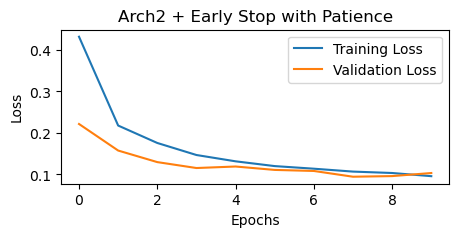

Neural Network Test Accuracy: 97.20%


In [93]:
### Attempt 6: Optimized Architecture 2 and Early Stop with Patience
train_losses, val_losses = [], []
criterion = nn.CrossEntropyLoss() #same as first run

mnist_nn_model_estop2 = SimpleNeuralNetV2()
optimizer = optim.Adam(mnist_nn_model_estop2.parameters(), lr=0.001) #same optimizer and LR as first run

train_earlystop_patience(mnist_nn_model_estop2, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot training and validation loss
plt.figure(figsize=(5, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Arch2 + Early Stop with Patience')
plt.legend()
plt.show()

nn_accuracy_estop2 = evaluate_nn(mnist_nn_model_estop2, test_loader)

In [96]:
accuracy_df["Arch6 = Arch2+Epochs+EarlyStopPatience"] = nn_accuracy_estop2
accuracy_df

,Baseline RandomForest,Simple NN,"Arch2 = Simple NN + layer,neurons",Arch3 = Arch2 + Dropout,Arch6 = Arch2+Epochs+EarlyStopPatience
0,0.9704,0.9632,0.9735,0.9669,0.972


 - Arch6 Wall time is double Arch2 while accuracy is still lesser by 0.1%. 

### Learning Rate

Options to Optimize LR
- Change LR manually like using GridSearch of below to find optimal LR 
- LR Scheduler: 
A learning rate scheduler modifies the global learning rate (all parameters) based on the current training epoch (high in the beginning and drops at later epochs). The purpose is Goal: Help the model converge more effectively by starting with a high learning rate for rapid progress, then reducing it to fine-tune weights toward the end of training. Readymade options like StepLR, ExponentialLR and ReduceLROnPlateau are available.
- Momentum in Optimizers:
Helps the optimizer escape local minima and improve convergence speed by adding inertia to parameter updates. When updating weights, momentum incorporates a fraction of the previous update (like rolling a ball downhill). This "momentum" smooths updates by amplifying movement in consistent directions and dampening oscillations. Goal: Accelerate convergence and reduce oscillations in steep areas of the loss surface. Eg: Adam. Adam adjusts learning rates per parameter and dynamically based on gradients, without any explicit scheduling.A LR scheduler, on the other hand, adjusts the global learning rate for all parameters, independent of the optimizer's calculations.

Completed LR trials for 0.01
Completed LR trials for 0.005
Completed LR trials for 0.001


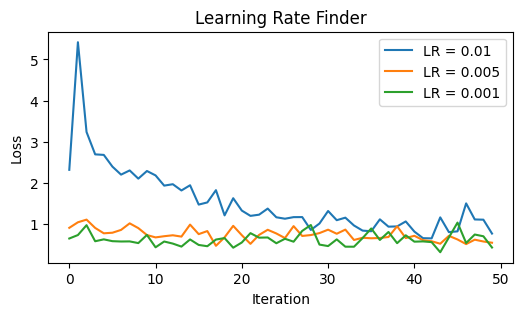

In [ ]:
# LR Search
def train_lr_search(model, train_loader, criterion, base_lr, num_iter=50):
    # Trying different learning rates: 0.01, 0.005, 0.001
    lrs = [0.01, 0.005, 0.001]
    losses = {lr: [] for lr in lrs}
    
    for lr in lrs:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Initialize the list of loss values for each learning rate
        model.train()
        
        for i, (inputs, labels) in enumerate(train_loader):
            if i >= num_iter:
                break
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization step
            loss.backward()
            optimizer.step()
            
            # Record loss for each learning rate
            losses[lr].append(loss.item())
            
        print(f"Completed LR trials for {lr}")
    
    # Plotting the results
    plt.figure(figsize=(6,3))
    for lr in lrs:
        plt.plot(losses[lr], label=f"LR = {lr}")
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')
    plt.legend()
    plt.show()


# Initialize the model and criterion
mnist_model_lrsearch = SimpleNeuralNetV2()
criterion = nn.CrossEntropyLoss()

# train_losses, val_losses = [], []
# Run the Learning Rate Finder with the specified learning rates
train_lr_search(mnist_model_lrsearch, train_loader, criterion, base_lr=0.001, num_iter=50)
